In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
np.random.seed(4747)

## Introducing, A Fully-Connected NN Model to Predict Temperature-anomaly based off Latitude, Longitude, Elevation, Species, Year, and d18O.

In [24]:
df = pd.read_csv('../../data_with_temp/all_coral_with_temp_fixed_1880-2012.csv')
df = df.drop('Unnamed: 0.1', 1)
df

,Unnamed: 0,lat,lon,elevation,species,year,d18o,temp_anom
0,0,11.170000,119.150000,-4,Montastaea faveolata,1927,-4.067500,-0.405418
1,1,11.170000,119.150000,-4,Montastaea faveolata,1928,-3.865000,-0.503512
2,2,11.170000,119.150000,-4,Montastaea faveolata,1929,-3.865000,-0.819141
3,3,11.170000,119.150000,-4,Montastaea faveolata,1930,-4.007500,-0.337399
4,4,11.170000,119.150000,-4,Montastaea faveolata,1931,-4.040000,-0.099585
...,...,...,...,...,...,...,...,...
9693,16816,20.666667,296.833333,-5,Porites sp.,2008,-5.474000,0.210579
9694,16817,20.666667,296.833333,-5,Porites sp.,2009,-5.249917,0.288014
9695,16818,20.666667,296.833333,-5,Porites sp.,2010,-5.299417,0.664223
9696,16819,20.666667,296.833333,-5,Porites sp.,2011,-5.397417,0.425456


Fixing typos acquired from the original text scraping.

In [25]:
df = df.replace(to_replace ="Porites.sp",
                 value ="Porites sp.")
df = df.replace(to_replace ="Porites.sp",
                 value ="Porites sp.")
df = df.replace(to_replace ="Montastaea faveolata",
                 value ="Montastraea faveolata")
df = df.replace(to_replace ="Montastraea faviolata",
                 value ="Montastraea faveolata")         
df = df.replace(to_replace ="Porites australiensis",
                 value ="Porites australiensus") 
         

One-hot encoding of the species.

In [26]:
encoder_df = pd.get_dummies(df[['species']], prefix='species')
df = df.join(encoder_df)
df

,Unnamed: 0,lat,lon,elevation,species,year,d18o,temp_anom,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0,11.170000,119.150000,-4,Montastraea faveolata,1927,-4.067500,-0.405418,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11.170000,119.150000,-4,Montastraea faveolata,1928,-3.865000,-0.503512,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,11.170000,119.150000,-4,Montastraea faveolata,1929,-3.865000,-0.819141,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,11.170000,119.150000,-4,Montastraea faveolata,1930,-4.007500,-0.337399,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,11.170000,119.150000,-4,Montastraea faveolata,1931,-4.040000,-0.099585,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9693,16816,20.666667,296.833333,-5,Porites sp.,2008,-5.474000,0.210579,0,0,...,0,0,0,0,0,1,0,0,0,0
9694,16817,20.666667,296.833333,-5,Porites sp.,2009,-5.249917,0.288014,0,0,...,0,0,0,0,0,1,0,0,0,0
9695,16818,20.666667,296.833333,-5,Porites sp.,2010,-5.299417,0.664223,0,0,...,0,0,0,0,0,1,0,0,0,0
9696,16819,20.666667,296.833333,-5,Porites sp.,2011,-5.397417,0.425456,0,0,...,0,0,0,0,0,1,0,0,0,0


Now, we want to predict `temp`, given `species`, `year`, `d18O`, `lat`, and `long`.

First, let's configure all the data into one big dataframe. But only for years after 1960 (those are the temperature years we're pretty sure about). We will want to save the data with years before 1960 as part of our test data.

Then, let's scale everything between 1 and 0 to make it more suitable for the neural network.

In [27]:
cols_to_use = ['lat', 'lon', 'elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

df_1960 = df[df['year']<2021]
df_1960 = df_1960[df_1960['year']>1959]

df_1960 = df_1960.dropna() # this removes a TON of data.... we should find a way to not have remove all the NaNs and instead fill them with something
df_1960 = df_1960.reset_index()
df_1960 = df_1960.drop(columns = ['index'])
df_1960 

X = df_1960[cols_to_use]
Y = df_1960['temp_anom']

In [28]:
X = X.reset_index()
X = X.drop(columns = ['index'])
X 

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.170000,119.150000,-4,-3.777500,1960,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.170000,119.150000,-4,-4.152500,1961,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.170000,119.150000,-4,-4.022500,1962,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.170000,119.150000,-4,-3.672500,1963,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.170000,119.150000,-4,-3.912500,1964,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,20.666667,296.833333,-5,-5.474000,2008,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2865,20.666667,296.833333,-5,-5.249917,2009,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2866,20.666667,296.833333,-5,-5.299417,2010,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2867,20.666667,296.833333,-5,-5.397417,2011,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
X = X[X['year'].notna()]
X = X[X['year']!='-999']
X = X[X['year']!='NAN']

X = X[X['elevation'].notna()]
X = X[X['elevation']!='-999']
X = X[X['elevation']!='NAN']
X['elevation'] = X['elevation'].apply(lambda x: x.strip('m'))

X['elevation'] = X['elevation'].apply(lambda x: float(x))
X['year'] = X['year'].apply(lambda x: float(x))

Scale all the input variables between -1 and 1.

In [30]:
from sklearn import preprocessing

In [31]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

cols = X.columns
d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(d, columns=cols)
X_scaled.head()


,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0.300928,-0.406596,0.819549,-0.026103,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.300928,-0.406596,0.819549,-0.107760,-0.962264,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.300928,-0.406596,0.819549,-0.079452,-0.924528,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.300928,-0.406596,0.819549,-0.003239,-0.886792,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.300928,-0.406596,0.819549,-0.055500,-0.849057,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [32]:
Y = Y.reset_index()
Y = Y.drop(columns = ['index'])
Y 

,temp_anom
0,-0.284105
1,-0.504643
2,-0.531974
3,-0.755829
4,-0.417459
...,...
2864,0.210579
2865,0.288014
2866,0.664223
2867,0.425456


In [17]:
# from sklearn.model_selection import train_test_split
# X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(
#     X_scaled, Y, test_size=0.2, random_state=47)

In [18]:
# X_val_and_test.shape, Y_val_and_test.shape

In [19]:
# X_val_and_test.index, Y_val_and_test.index

In [20]:
# X_train.shape, Y_train.shape

In [33]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [34]:
from numpy.random import seed
seed(47)

## Full-Connected Neural Network

In [35]:
network = Sequential()

#input layer
network.add(Dense(8, input_shape=(25,), activation='LeakyReLU'))

#middle layers
network.add(Dense(6, activation='LeakyReLU'))
network.add(Dropout(0.2))

network.add(Dense(6, activation='LeakyReLU'))

network.add(Dense(4, activation='LeakyReLU'))
network.add(Dropout(0.2))

#output layer
network.add(Dense(1, activation='LeakyReLU'))

network.compile('adam', loss='mse', metrics=['mse'])
#network.fit(X_train, Y_train, epochs=200)
network.fit(X_scaled, Y, epochs=50)

Epoch 1/50
90/90 [==============================] - 1s 1ms/step - loss: 0.1499 - mse: 0.1499
Epoch 2/50
90/90 [==============================] - 0s 829us/step - loss: 0.1290 - mse: 0.1290
Epoch 3/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1238 - mse: 0.1238
Epoch 4/50
90/90 [==============================] - 0s 897us/step - loss: 0.1192 - mse: 0.1192
Epoch 5/50
90/90 [==============================] - 0s 891us/step - loss: 0.1132 - mse: 0.1132
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1085 - mse: 0.1085
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1039 - mse: 0.1039
Epoch 8/50
90/90 [==============================] - 0s 858us/step - loss: 0.1018 - mse: 0.1018
Epoch 9/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0981 - mse: 0.0981
Epoch 10/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0970 - mse: 0.0970
Epoch 11/50
90/90 [==============================] - 0s 905us

In [ ]:
# network.evaluate(X_val_and_test, Y_val_and_test)

18/18 [==============================] - 0s 663us/step - loss: 0.0837 - mse: 0.0837


[0.08372066915035248, 0.08372066915035248]

This network with a dropout layer produces a teeny loss, maybe we're overfitting?

In [ ]:
# actual = pd.DataFrame(Y_val_and_test, columns=["temp_anom"])
# predicted = pd.DataFrame(network.predict(X_val_and_test), columns=["pred"])
# actual.head(), predicted.head()

In [ ]:
# predicted['index'] = actual.index
# predicted = predicted.set_index(['index'])
# predicted['index'] = actual.index
# predicted = predicted.set_index(['index'])
# predicted

In [ ]:
# actual_v_pred = actual.join(predicted, how = "inner")
# actual_v_pred

In [ ]:
# from sklearn.metrics import mean_squared_error
# mean_squared_error(Y_val_and_test, predicted)

In [ ]:
# test_data_with_preds = actual_v_pred.join(X_val_and_test, how = "inner")
# test_data_with_preds['diff'] = test_data_with_preds['temp_anom'] - test_data_with_preds['pred']
# test_data_with_preds

In [ ]:
# x = test_data_with_preds['temp_anom']
# y = test_data_with_preds['pred']
# plt.scatter(test_data_with_preds['temp_anom'], test_data_with_preds['pred'], color="pink")
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# plt.xlim([-2, 1.5])
# plt.ylim([-2, 1.5])
# plt.title('Actual v. Predicted Gridded Temperature Anomaly')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

In [ ]:
# x = test_data_with_preds['d18o']
# y = test_data_with_preds['diff']
# plt.scatter(test_data_with_preds['d18o'], test_data_with_preds['diff'], color="purple")
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# plt.xlim([-1, 1])
# plt.ylim([-1.5, 1.5])
# plt.title('d18O v. Gridded Temperature Anomaly Error')
# plt.xlabel('d18O')
# plt.ylabel('Temp Error')

In [ ]:
# plt.scatter(test_data_with_preds['lat'], test_data_with_preds['diff'])

In [ ]:
# plt.scatter(test_data_with_preds['lon'], test_data_with_preds['diff'], color="orange")

Let's now take all of our predictions, average them by year

In [ ]:
# test_data_with_preds.boxplot(column = ['pred', 'temp_anom'])

In [ ]:
# annual_temp_and_preds = test_data_with_preds[['temp_anom', 'pred']].join(X, how="inner")
# annual_compare = annual_temp_and_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()
# annual_compare.head()

In [ ]:
# plt.plot(annual_compare['year'], annual_compare['temp_anom']), plt.plot(annual_compare['year'], annual_compare['pred'])

Sweet --- looks like we've at least followed the general trend of global warming :)

In [ ]:
# np.corrcoef(annual_compare['temp_anom'], annual_compare['pred'])

In [ ]:
# np.var(annual_compare['temp_anom']), np.var(annual_compare['pred'])

We should note that our predictions do not vary as much as the actual values.

In [ ]:
# annual_compare.to_csv('preds_1960-2012_WITHIN.csv')

Let's see how our model performs on the years prior to 1960.

In [36]:
cols_to_use = ['lat', 'lon', 'elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

df_past = df[df['year']<1960]

df_past = df_past.dropna()
df_past = df_past.reset_index()
df_past = df_past.drop(columns = ['index'])
df_past 

X_past = df_past[cols_to_use]
Y_past = df_past['temp_anom']

In [37]:
X_past = X_past.reset_index()
X_past = X_past.drop(columns = ['index'])
X_past

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.17,119.15,-4,-4.067500,1927,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.17,119.15,-4,-3.865000,1928,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.17,119.15,-4,-3.865000,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.17,119.15,-4,-4.007500,1930,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.17,119.15,-4,-4.040000,1931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,5.87,17.87,-10,-4.753333,1955,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4026,5.87,17.87,-10,-4.785000,1956,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4027,5.87,17.87,-10,-4.924167,1957,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4028,5.87,17.87,-10,-5.017500,1958,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [38]:
X_past = X_past[X_past['year'].notna()]
X_past = X_past[X_past['year']!='-999']
X_past = X_past[X_past['year']!='NAN']

X_past = X_past[X_past['elevation'].notna()]
X_past = X_past[X_past['elevation']!='-999']
X_past = X_past[X_past['elevation']!='NAN']
X_past['elevation'] = X_past['elevation'].apply(lambda x: x.strip('m'))

X_past['elevation'] = X_past['elevation'].apply(lambda x: float(x))
X_past['year'] = X_past['year'].apply(lambda x: float(x))

In [39]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

cols = X_past.columns
d = scaler.fit_transform(X_past)
X_past = pd.DataFrame(d, columns=cols)
X_past.head()

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0.300928,-0.406596,0.819549,-0.445162,0.189873,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.300928,-0.406596,0.819549,-0.397605,0.215190,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.300928,-0.406596,0.819549,-0.397605,0.240506,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.300928,-0.406596,0.819549,-0.431071,0.265823,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.300928,-0.406596,0.819549,-0.438704,0.291139,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [40]:
Y_past = Y_past.reset_index()
Y_past = Y_past.drop(columns = ['index'])
Y_past 

,temp_anom
0,-0.405418
1,-0.503512
2,-0.819141
3,-0.337399
4,-0.099585
...,...
4025,-0.679975
4026,-0.700354
4027,-0.415288
4028,-0.047501


Use this functionality to convert `X_past` and `Y_past` from `nparrays` to `tensors`

In [41]:
actual_past = pd.DataFrame(Y_past, columns=["temp_anom"])
predicted_past = pd.DataFrame(network.predict(X_past), columns=["pred"])
actual_past.head(), predicted_past.head()

(   temp_anom
 0  -0.405418
 1  -0.503512
 2  -0.819141
 3  -0.337399
 4  -0.099585,
        pred
 0  0.054225
 1  0.065634
 2  0.076877
 3  0.088300
 4  0.099271)

In [42]:
network.evaluate(X_past, Y_past)

126/126 [==============================] - 0s 792us/step - loss: 0.4377 - mse: 0.4377


[0.4377334415912628, 0.4377334415912628]

We have a much larger `test` loss than we did within the ranges of our training bounds. 

In [43]:
actual_v_pred_past = actual_past.join(predicted_past, how = "inner")
actual_v_pred_past

,temp_anom,pred
0,-0.405418,0.054225
1,-0.503512,0.065634
2,-0.819141,0.076877
3,-0.337399,0.088300
4,-0.099585,0.099271
...,...,...
4025,-0.679975,0.383892
4026,-0.700354,0.390154
4027,-0.415288,0.396816
4028,-0.047501,0.403307


In [44]:
past_data_with_preds = actual_v_pred_past.join(X_past, how = "inner")
past_data_with_preds['diff'] = actual_v_pred_past['temp_anom'] - actual_v_pred_past['pred']
past_data_with_preds

,temp_anom,pred,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,...,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni,diff
0,-0.405418,0.054225,0.300928,-0.406596,0.819549,-0.445162,0.189873,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.459642
1,-0.503512,0.065634,0.300928,-0.406596,0.819549,-0.397605,0.215190,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.569146
2,-0.819141,0.076877,0.300928,-0.406596,0.819549,-0.397605,0.240506,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.896018
3,-0.337399,0.088300,0.300928,-0.406596,0.819549,-0.431071,0.265823,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.425699
4,-0.099585,0.099271,0.300928,-0.406596,0.819549,-0.438704,0.291139,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.198857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,-0.679975,0.383892,0.126953,-0.999982,0.729323,-0.606231,0.898734,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.063867
4026,-0.700354,0.390154,0.126953,-0.999982,0.729323,-0.613668,0.924051,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.090508
4027,-0.415288,0.396816,0.126953,-0.999982,0.729323,-0.646352,0.949367,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.812103
4028,-0.047501,0.403307,0.126953,-0.999982,0.729323,-0.668271,0.974684,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.450808


([<matplotlib.lines.Line2D at 0x7f9bfa5ac460>],
 [<matplotlib.lines.Line2D at 0x7f9bfa5ac730>])

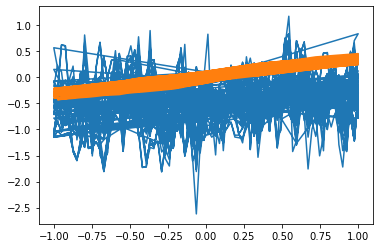

In [45]:
plt.plot(past_data_with_preds['year'], past_data_with_preds['temp_anom']), plt.plot(past_data_with_preds['year'], past_data_with_preds['pred'])

In [46]:
annual_temp_and_preds = past_data_with_preds[['temp_anom', 'pred']].join(X, how="inner")
annual_compare = past_data_with_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()
annual_compare

<ipython-input-46-2651521bf6e3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  annual_compare = past_data_with_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()


,year,temp_anom,pred
0,-1.000000,-0.580696,-0.301994
1,-0.974684,-0.437284,-0.304912
2,-0.949367,-0.448660,-0.292852
3,-0.924051,-0.535872,-0.288944
4,-0.898734,-0.577859,-0.279507
...,...,...,...
75,0.898734,-0.628892,0.326655
76,0.924051,-0.655931,0.332992
77,0.949367,-0.272213,0.338390
78,0.974684,-0.251039,0.346113


([<matplotlib.lines.Line2D at 0x7f9bfa9e9400>],
 [<matplotlib.lines.Line2D at 0x7f9bfa9e9790>])

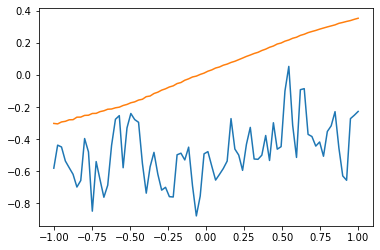

In [47]:
plt.plot(annual_compare['year'], annual_compare['temp_anom']), plt.plot(annual_compare['year'], annual_compare['pred'])

Our network very much over-predicted the `temp_anom`. Probalby because it over-fit to the traiign data which had higher temp anomalies.

In [48]:
annual_compare['year'] = np.arange(1880, 1960, 1)
annual_compare

,year,temp_anom,pred
0,1880,-0.580696,-0.301994
1,1881,-0.437284,-0.304912
2,1882,-0.448660,-0.292852
3,1883,-0.535872,-0.288944
4,1884,-0.577859,-0.279507
...,...,...,...
75,1955,-0.628892,0.326655
76,1956,-0.655931,0.332992
77,1957,-0.272213,0.338390
78,1958,-0.251039,0.346113


In [49]:
annual_compare.to_csv('../../models/fully_connected_nn/preds_1880-1960_OUTSIDE.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'models/fully_connected_nn/preds_1880-1960_OUTSIDE.csv'